In [1]:
from netCDF4 import Dataset
import cchdo_tools as cchdo
import matplotlib.pyplot as plt
import numpy as np
import gsw
import cartopy.crs as ccrs
import cartopy.feature as cfeature


## Demo comparing CanNEMO CMOC to obs
First specify the fields that we want to plot giving separate variable names for the WOCE standard and the NEMO output Note that the order matters.

In [2]:
woce_fields = ['bottle_oxygen','total_carbon','nitrate']
nemo_fields = ['O2', 'DIC', 'NO3']

Now we can point to the path where the cruise data are stored. In this case here, we're extracting every cruise that can be found in 'datapath'

In [3]:
datapath = '/HOME/ras/datasets/cchdo/subset/'
cchdo.update_expo_list(datapath = datapath)
cruises = cchdo.extract_all_expos(datapath = datapath, fields_in = woce_fields)
remap_fields = woce_fields + ['pressure']
obs_remap = {}

/HOME/ras/python/cchdo_toolkit/cchdo_tools.py:171: RuntimeWarning: invalid value encountered in greater
  tempvar = expo_ncvars[field][:]
/HOME/ras/python/cchdo_toolkit/cchdo_tools.py:167: RuntimeWarning: invalid value encountered in greater
  tempvar = expo_ncvars[field][:]


The next block of code does the objective mapping. The optional fields 'xvar' specifies which variable to use along the x-axis. This can be 'longitude' or 'latitude', but I prefer distance (which is the total distance that the ship had traversed since the first station) since it's an actual distance unit and makes the gridding more consistent. 'yvar' can either be 'pressure' or 'sigma0', 'sigma2', 'rhoinsitu'. Here I'm choosing sigma2 because we're plotting full-depth variables. I prefer to smooth in density space because most measured quantities have consistent density correlations rather than pressure-based correlations. Note that this part of the routine can take quite a bit of time to compute and potentially a lot of memory.

In [4]:
for expo in cruises.keys():
  obs_remap[expo] = cchdo.grid_transect_variables(cruises[expo]['bottle'], remap_fields,xvar='distance',yvar='sigma2',xcorr=5e5,ycorr=0.05,nx=100,ny=40,npass=2)

Now we're extracting some of the necessary fields from NEMO so we can grid variables onto the transect

In [5]:
physfile = '/HOME/ras/model_output/cccma/ofb-502/ofb-502_1m_89040101_89041231_grid_T.nc'
bgcfile  = '/HOME/ras/model_output/cccma/ofb-502/ofb-502_1m_89040101_89041231_ptrc_T.nc'
phys_fields = ['votemper','vosaline','deptht','nav_lon','nav_lat'];
model = {}
for field in phys_fields:
  model[field] = Dataset(physfile).variables[field][:].copy()
Dataset(physfile).close()
for field in nemo_fields:
  model[field] = Dataset(bgcfile).variables[field][:].copy()
Dataset(bgcfile).close()
model['sigma2'] = gsw.density.sigma2(model['vosaline'],model['votemper'])

The next block handles the regridding of the model output onto the transect and the plotting

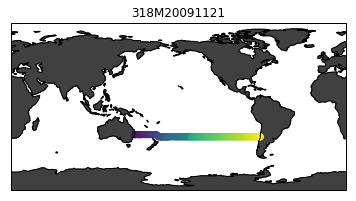

/HOME/ras/miniconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


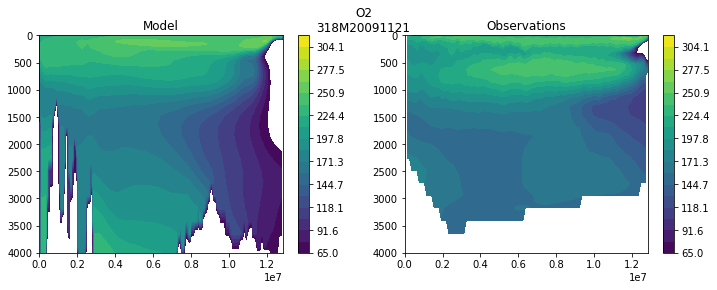

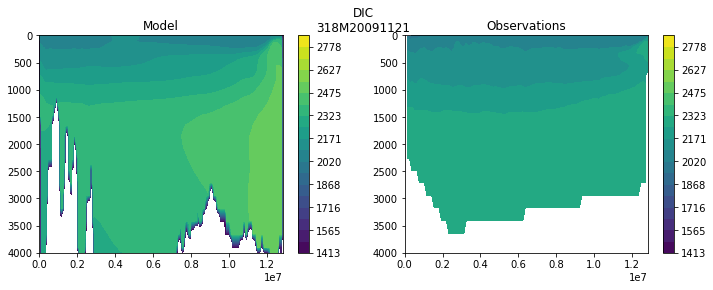

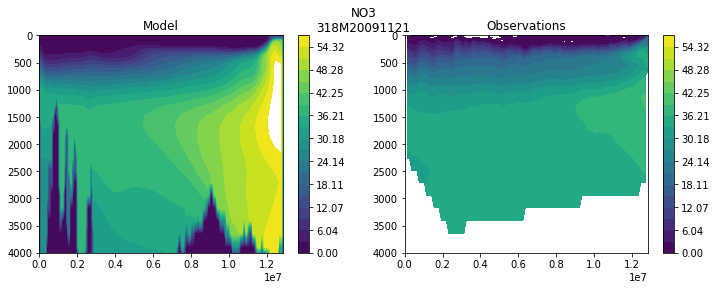

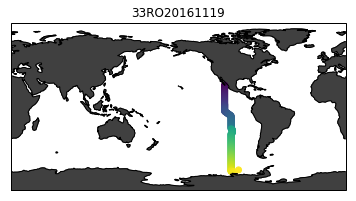

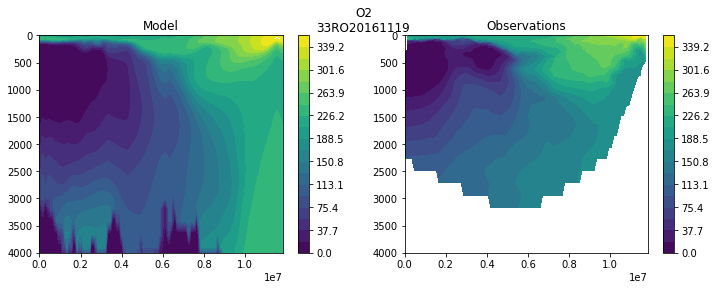

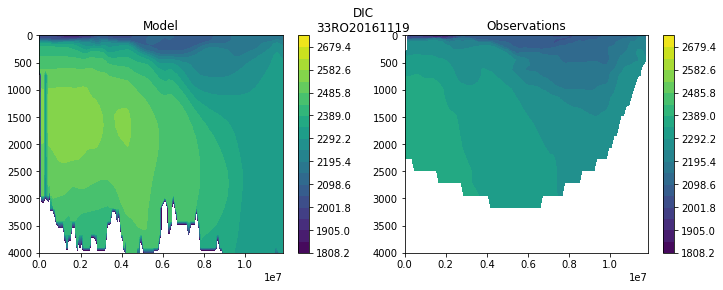

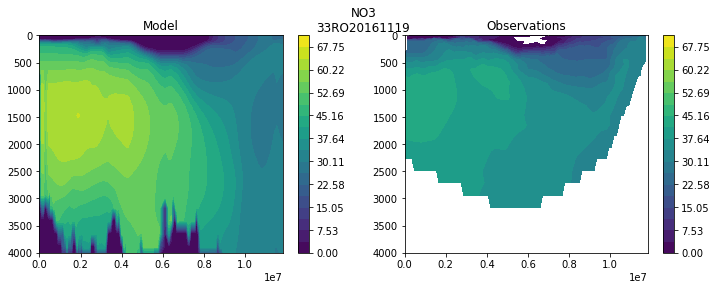

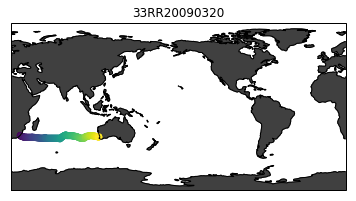

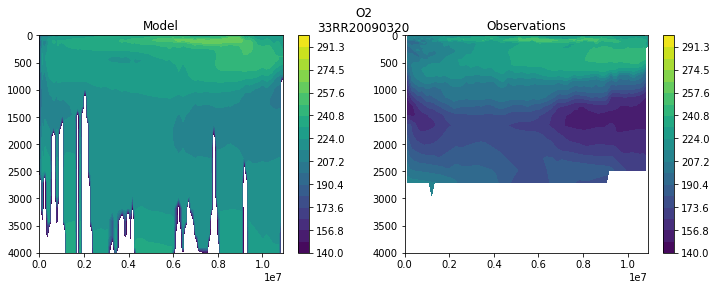

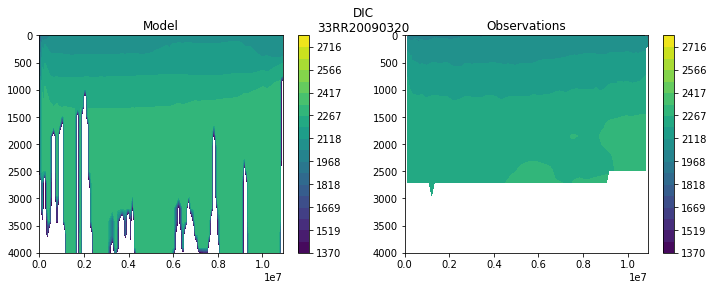

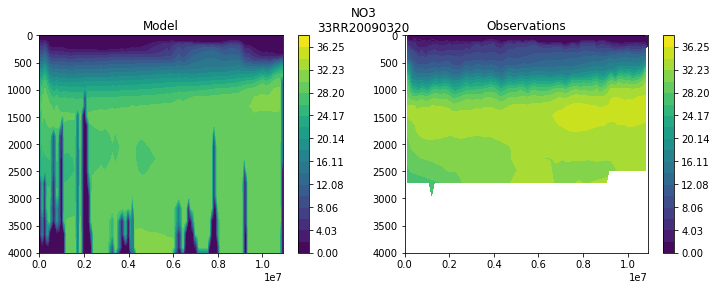

In [6]:
fields_to_remap = ['votemper','vosaline','sigma2']+nemo_fields;
model_remap = {}
proj = ccrs.PlateCarree(central_longitude=0.5*(20+380))
scale = 2
ncontour = 20
yvar = 'pressure'
for expo in cruises.keys():
  model_remap[expo] = cchdo.map_gridded_fields_to_expo(cruises[expo]['station'],model,fields_to_remap)
  fig = plt.figure()
  ax = plt.axes(projection=proj)
  ax.scatter(cruises[expo]['station']['longitude'],cruises[expo]['station']['latitude'], c = cruises[expo]['station']['time'], transform=ccrs.PlateCarree())
  ax.add_feature(cfeature.COASTLINE)
  ax.add_feature(cfeature.LAND,facecolor='0.25')
  ax.set_global()
  plt.title(expo.upper())
  plt.show()

  for idx in range(0,len(woce_fields)):
    
    modelval = model_remap[expo][nemo_fields[idx]]
    modelval = np.ma.masked_where(modelval == 0., modelval)
    meanval = modelval.mean()
    std = modelval.std()
    minval = max(meanval - std*scale, 0.)
    maxval = meanval + std*scale
    contours = np.linspace(minval,maxval,ncontour)        
    ylim = (obs_remap[expo][yvar].min(),obs_remap[expo][yvar].max()) 
    ylim = (0,4000)
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.contourf(model_remap[expo]['distance'],model_remap[expo][yvar],model_remap[expo][nemo_fields[idx]],contours)
    plt.ylim(ylim)
    plt.title('Model')
    plt.gca().invert_yaxis()
    plt.colorbar()
    plt.subplot(1,2,2)
    obs_pressure = cchdo.remap_fields(obs_remap[expo], woce_fields, 'distance', 'sigma2', 'pressure', ynew = model['deptht'])  
    plt.contourf(obs_pressure['distance'],obs_pressure['pressure'],obs_pressure[woce_fields[idx]],contours)
    plt.colorbar()
    plt.ylim(ylim)
    plt.gca().invert_yaxis()    
    plt.title('Observations')
    plt.suptitle("%s\n%s" % (nemo_fields[idx],expo))
    plt.show()
  